In [1]:
#importanto libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scy
import geopandas
from shapely.geometry import Point

# Análise da base de dados -  Involves

**INSTRUÇÕES:** Faça agora uma análise da base de dados que está no link abaixo e relacione de 5 a 10 insights que você considera mais importantes. Capriche, mostre aqui todo seu potencial. 

## Visitas

Primeiro vamos importar e fazer uma análise inicial da primeira planilha, que chamaremos de "Visitas".

In [2]:
visitas = pd.read_excel('Base de Dados para Prova de Data Scientist v1.xlsx', sheet_name= 'Visitas')

In [3]:
visitas.head()

,Colaborador,Colaborador Superior,Regional,Rede,Bandeira,Ponto de Venda,Tipo PDV,Código do PDV,Perfil PDV,Canal PDV,...,Pesquisas Realizadas,Pesquisas Previstas,Respondeu Todas as Pesquisas,Total de Fotos,Tempo em Loja realizado - Manual,Tempo em Loja realizado - GPS,Tempo em Loja Previsto,Saldo,Atraso Entrada - Checkin Manual,Atraso Entrada - Checkin GPS
0,Abel Malafaia,Adelino León,REGIONAL SAO PAULO,SILVA E BARBOSA COMERCIO DE ALIM,BARBOSA,SILVA E BARBOSA COMERCIO DE AL 0001,NaN,20133,NaN,Médio Varejo,...,0,0,Não,0,00:00:00,00:00:00,01:00:00,NaN,00:00:00,00:00:00
1,Abel Malafaia,Adelino León,REGIONAL SAO PAULO,SUPERM IRM LOPES SA,LOPES SUPERMERCADOS,SUPERM IRM LOPES SA LJ 08 0009,NaN,18622,NaN,Contas-Chave Regionais,...,0,0,Não,0,00:00:00,00:00:00,01:00:00,NaN,00:00:00,00:00:00
2,Abel Malafaia,Adelino León,REGIONAL SAO PAULO,SP BRASIL ATACADO VAREJ GEN LTDA LJ,NAGUMO,BOM BRASIL COM DE ALIMENTOS L 0001,NaN,46179,NaN,Contas-Chave Regionais,...,39,35,Sim,0,04:15:45,00:00:00,00:00:00,NaN,00:00:00,00:00:00
3,Iara Madruga,Ana Noronha,REGIONAL SAO PAULO,CIA BRAS DE DISTRIBUICAO,0,MIXTER ATACADO E VAREJO DE GEN 0006,10 a 19 Check outs,68901,NaN,Contas-Chave Regionais,...,36,36,Sim,0,04:14:09,04:16:20,02:00:00,02:14:09,00:00:00,00:00:00
4,Priscila Beltrán,Adelino León,REGIONAL SAO PAULO,ATACADAO S A,ATACADÃO S/A,ATACADAO S A 0120,NaN,48554,NaN,Especial (Atacadão),...,41,41,Sim,10,03:42:42,03:53:35,02:40:00,01:02:42,00:00:00,00:00:00


In [4]:
# Selecionar colununas que serão utilizadas

visitas =  visitas[['Rede','Bandeira', 'Cidade','Estado','Tipo PDV', 'Canal PDV',
                                   'Razão não Visitou', 'Tempo em Loja realizado - Manual',
                                   'Tempo em Loja realizado - GPS','Tempo em Loja Previsto']]

As colunas referente a tempos se encontram em um formato strings (caractéres) e não podem ser trabalhadas assim. Portanto serão transformadas para o formtato de tempo (hh:mm:ss)

In [5]:
# Transformar as colunas de texto (strings) para o formtato de tempo (hh:mm:ss)

visitas['Tempo em Loja realizado - Manual'] = pd.to_timedelta(visitas['Tempo em Loja realizado - Manual'])
visitas['Tempo em Loja realizado - GPS'] = pd.to_timedelta(visitas['Tempo em Loja realizado - GPS'])
visitas['Tempo em Loja Previsto'] = pd.to_timedelta(visitas['Tempo em Loja Previsto'])


In [6]:
# Criar novas colunas com valores em minutos

visitas['Dif Manual / GPS (min)'] = ((visitas['Tempo em Loja realizado - Manual'] - visitas['Tempo em Loja realizado - GPS']).dt.total_seconds())/60
visitas['Dif Manual/ Prev (min)'] = ((visitas['Tempo em Loja realizado - Manual'] - visitas['Tempo em Loja Previsto']).dt.total_seconds())/60
visitas['Tempo GPS (minutos)'] = ((visitas['Tempo em Loja realizado - GPS']).dt.total_seconds())/60

# Nova DataFrame com o resumo das colunas referentes a tempo

df = visitas[['Tipo PDV','Tempo em Loja realizado - Manual', 'Tempo em Loja realizado - GPS', 'Tempo em Loja Previsto',
              'Dif Manual / GPS (min)','Dif Manual/ Prev (min)', 'Tempo GPS (minutos)']]

# Eliminar outliers: tempo muito alto (acima de 6 horas) ou igual a zero
df = df[(df['Tempo em Loja realizado - Manual'] > pd.Timedelta('00:00:00')) & (df['Tempo em Loja realizado - Manual'] < pd.Timedelta('06:00:00'))]
df= df[(df['Tempo em Loja realizado - GPS'] > pd.Timedelta('00:00:00')) & (df['Tempo em Loja realizado - GPS'] < pd.Timedelta('06:00:00'))]
df= df[(df['Tempo em Loja Previsto'] > pd.Timedelta('00:00:00')) & (df['Tempo em Loja Previsto'] < pd.Timedelta('06:00:00'))]
df= df[(df['Tempo GPS (minutos)'] > 0) & (df['Tempo GPS (minutos)'] < 500)]
df.dropna(inplace= True)
df.shape

(453, 7)

In [7]:
#SUMMARY STATS DOS TEMPOS DE VISITA
df.describe()

,Tempo em Loja realizado - Manual,Tempo em Loja realizado - GPS,Tempo em Loja Previsto,Dif Manual / GPS (min),Dif Manual/ Prev (min),Tempo GPS (minutos)
count,453,453,453,453.000000,453.000000,453.000000
mean,0 days 02:10:25.869757,0 days 02:08:08.355408,0 days 01:47:13.377483,2.291906,23.208205,128.139257
std,0 days 01:10:27.377589,0 days 01:12:41.556652,0 days 00:25:28.774838,44.208118,67.416371,72.692611
min,0 days 00:05:15,0 days 00:05:02,0 days 01:00:00,-237.233333,-106.866667,5.033333
25%,0 days 01:19:03,0 days 01:16:26,0 days 01:30:00,-9.316667,-26.883333,76.433333
50%,0 days 01:56:46,0 days 01:54:41,0 days 02:00:00,-4.033333,15.083333,114.683333
75%,0 days 02:58:28,0 days 02:51:48,0 days 02:00:00,2.233333,65.116667,171.800000
max,0 days 05:49:00,0 days 05:51:38,0 days 03:00:00,273.733333,259.000000,351.633333


In [8]:
#REDE COM MENOR TEMPO DE VISITA
df['Tempo GPS (minutos)'].idxmin()
visitas.iloc[5513]

Rede                                  CIAL ZARAGOZA IMPOR E EXPORT LTDA
Bandeira                            COMERCIAL ZARAGOZA IMPORTACAO E EXP
Cidade                                                             Mauá
Estado                                                               SP
Tipo PDV                                             10 a 19 Check outs
Canal PDV                                                      Atacados
Razão não Visitou                                                   NaN
Tempo em Loja realizado - Manual                        0 days 03:40:31
Tempo em Loja realizado - GPS                           0 days 00:05:02
Tempo em Loja Previsto                                  0 days 02:00:00
Dif Manual / GPS (min)                                          215.483
Dif Manual/ Prev (min)                                          100.517
Tempo GPS (minutos)                                             5.03333
Name: 5513, dtype: object

In [9]:
#REDE COM MAIOR TEMPO DE VISITA
df['Tempo GPS (minutos)'].idxmax()
visitas.iloc[17587]

Rede                                SUPERMERCADO KRILL DE PERUIBE LTDA
Bandeira                                                         KRILL
Cidade                                                        Mongaguá
Estado                                                              SP
Tipo PDV                                              1 a 4 Check outs
Canal PDV                                       Contas-Chave Regionais
Razão não Visitou                                                  NaN
Tempo em Loja realizado - Manual                       0 days 05:40:42
Tempo em Loja realizado - GPS                          0 days 05:51:38
Tempo em Loja Previsto                                 0 days 02:00:00
Dif Manual / GPS (min)                                        -10.9333
Dif Manual/ Prev (min)                                           220.7
Tempo GPS (minutos)                                            351.633
Name: 17587, dtype: object

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


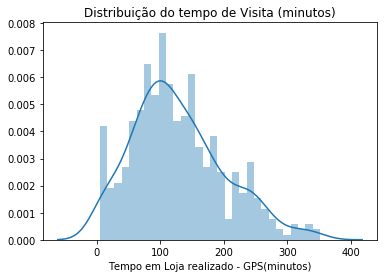

In [10]:
# DISTRIBUIÇÃO DO TEMPO DE VISITA
plt1 = sns.distplot(df['Tempo GPS (minutos)'], bins=30, axlabel = 'Tempo em Loja realizado - GPS(minutos)')
plt1= plt.title('Distribuição do tempo de Visita (minutos)')

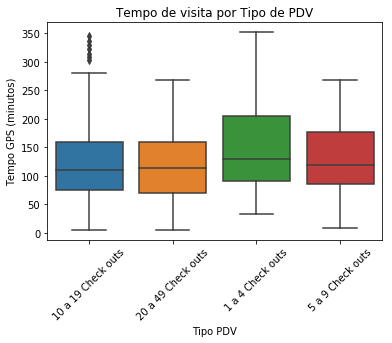

In [11]:
#TEMPO DE VISITA POR TIPO DE PDV
tx = sns.boxplot('Tipo PDV', 'Tempo GPS (minutos)', data = df, width=0.8)
tx= tx.set_xticklabels(tx.get_xticklabels(),rotation=45)
tx = plt.title('Tempo de visita por Tipo de PDV')

## INSIGHTS #1 - VISITAS

- O tempo médio de uma visita ao PDV, sem avaliar o tamanho dele, fica em torno de 132 minutos.

- A visita mais rápida levou apenas 5 minutos. Ela foi feita no PDV COMERCIAL ZARAGOZA IMPORTACAO E EXP na cidade de Mauá - SP.

- A vista mais longa 351 minutos, aproximadamente 5 horas e 51 minutos. Ela foi feita no PDV KRILL na cidade de Mongaguá - SP. Curiosamente esse PDV possuí entre 1 e 4 Check outs. 

- Os tempos de visitas, monitorado por GPS possuem uma distribuição normal. Podemos assim afirmar que, independente do tamanho do PDV, uma visita deve levar em condições normais entre 76 e 171 minutos.

- Dados referentes ao tempo médio de visita por Tipo de PDV.

        TEMPO MÉDIO DE VISITA por Tipo PDV
        1 a 4 Check outs      153.585749 minutos
        5 a 9 Check outs      127.537619 minutos
        10 a 19 Check outs    127.042857 minutos
        20 a 49 Check outs    117.663242 minutos

In [12]:
df.groupby('Tipo PDV').agg(['sum', 'mean', 'std','max'])

Dif Manual / GPS (min)                                    \
                                      sum       mean        std         max   
Tipo PDV                                                                      
1 a 4 Check outs              -961.300000 -13.931884  37.334884   70.316667   
10 a 19 Check outs            1828.716667  10.885218  55.159008  215.483333   
20 a 49 Check outs             188.716667   1.292580  35.909302  273.733333   
5 a 9 Check outs               -17.900000  -0.255714  30.058571  140.633333   

                   Dif Manual/ Prev (min)                                    \
                                      sum       mean        std         max   
Tipo PDV                                                                      
1 a 4 Check outs              2466.116667  35.740821  79.972999  227.783333   
10 a 19 Check outs            3821.916667  22.749504  68.433932  236.000000   
20 a 49 Check outs            2947.550000  20.188699  63.541990  259.000000   
5 a 9 Check outs              1277.733333  18.253333  58.724557  148.950000   

                   Tempo GPS (minutos)                                     
                                   sum        mean        std         max  
Tipo PDV                                                                   
1 a 4 Check outs          10597.416667  153.585749  79.920317  351.633333  
10 a 19 Check outs        21343.200000  127.042857  77.612554  345.516667  
20 a 49 Check outs        17178.833333  117.663242  65.794162  268.300000  
5 a 9 Check outs           8927.633333  127.537619  61.332638  268.616667

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


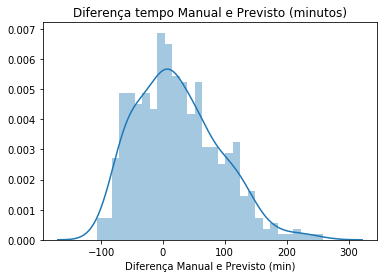

In [13]:
# PLOT DA DIFERENÇA ENTRE E EXECUTADO PREVISTO 
r = sns.distplot(df['Dif Manual/ Prev (min)'], bins=30, axlabel = 'Diferença Manual e Previsto (min)')
r = plt.title('Diferença tempo Manual e Previsto (minutos)')

Text(0.5, 1.0, 'Tipo PDV e Diferença Manual/ Prev (min)')

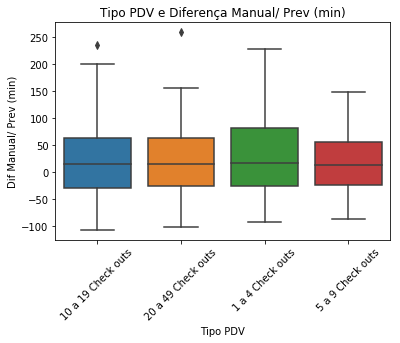

In [14]:
# DIFERENÇA MANUAL E PREVISTO POR TIPO DE PDV
ax = sns.boxplot('Tipo PDV', 'Dif Manual/ Prev (min)', data = df, width=0.8)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('Tipo PDV e Diferença Manual/ Prev (min)')

In [15]:
# IQR DO DA DIFERENÇA ENTRE MANUAL E GPS
scy.iqr(df['Dif Manual / GPS (min)'])

11.55

In [16]:
# IQR DO DA DIFERENÇA ENTRE MANUAL E PREVISTO
scy.iqr(df['Dif Manual/ Prev (min)'])

92.0

In [17]:
# TEMPO MÉDIO POR TIPO DE PDV
df.groupby(['Tipo PDV']).mean()['Tempo GPS (minutos)']

Tipo PDV
1 a 4 Check outs      153.585749
10 a 19 Check outs    127.042857
20 a 49 Check outs    117.663242
5 a 9 Check outs      127.537619
Name: Tempo GPS (minutos), dtype: float64

In [18]:
#SUMMARY STATS DA DIF. ABSOLUTA ENTRE EXECUTADO E PREVISTO
abs(df['Dif Manual/ Prev (min)']).describe()

count    453.000000
mean      55.567439
std       44.611747
min        0.350000
25%       21.300000
50%       47.916667
75%       77.150000
max      259.000000
Name: Dif Manual/ Prev (min), dtype: float64

In [19]:
#SUMMARY STATS DA DIF. ABSOLUTA ENTRE MANUAL E GPS 
abs(df['Dif Manual / GPS (min)']).describe()

count    453.000000
mean      24.702723
std       36.715767
min        0.066667
25%        3.866667
50%        8.000000
75%       29.816667
max      273.733333
Name: Dif Manual / GPS (min), dtype: float64

## INSIGHTS #2 - GPS VS MANUAL VS PREVISTO

- O erro médio entre o tempo manual e o previsto é um valor positivo de 23.21 minutos, o que quer dizer que o valor previsto é inferior a realidade. 
- Em termos de erro absoluto a média de erro é de 55.6 minutos. 
- Como podemos observar no boxplot 'Tipo PDV e Diferença Manual/ Prev (min)', o tempo de erro entre o tempo manual e o previsto ocorre independente do Tipo de PDV. Já que a mediana e o IQR são semelhantes entre os grupos.
- O erro médio entre o Tempo em Loja realizado - Manual e o Tempo em Loja realizado - GPS é de 24 minutos, sendo que a diferença máxima foi de 274 minutos e a mínima foi de 0.06 minutos, o que é muito próximo do ideal.


In [20]:
pdv = pd.read_excel('Base de Dados para Prova de Data Scientist v1.xlsx', sheet_name= 'PDVs')
pdv.head()

,Nome do PDV,Bandeira,Rede,Tipo do PDV,Canal do PDV,Regional,Macro Regional,Cidade,UF,Logradouro,Número,Complemento,Bairro,CEP,Latitude,Longitude
0,2M COMERCIO ALIMENTICIO LTDA 0001,SUPERMERCADOS CARINHO,2M COMERCIO ALIMENTICIO LTDA,5 a 9 Check outs,Contas-Chave Regionais,REGIONAL MINAS GERAIS,Macro Regional REGIONAL MINAS GERAIS,Ubá,MG,R CEL G TEIXEIRA DE ABREU 569,NaN,NaN,CENTRO,36500000,"""-21.115482""","""-42.943907"""
1,5M CIAL ATAC VAREJ DE ALIM LT 0001,BEM BARATO,5M CIAL ATAC VAREJ DE ALIM LTDA ME-010250585,NaN,Contas-Chave Regionais,REGIONAL SAO PAULO,Macro Regional REGIONAL SAO PAULO,São Bernardo do Campo,SP,RUA VITORIO BERNADELLO 77,NaN,NaN,JARDIM IMPERADOR,09851070,"""-23.718141""","""-46.5846075"""
2,5M CIAL ATAC VAREJ DE ALIM LTD 0003,BEM BARATO,5M CIAL ATAC VAREJ DE ALIM LTDA ME-010250585,NaN,Contas-Chave Regionais,REGIONAL SAO PAULO,Macro Regional REGIONAL SAO PAULO,São Bernardo do Campo,SP,RUA ALFERES BONILHA 90,NaN,NaN,CENTRO,09721230,"""-23.7140239""","""-46.5511428"""
3,5M COMERCIO ATACADISTA E VAREJ 0004,5M COMERCIO ATACADISTA E VAREJ,5M CIAL ATAC VAREJ DE ALIM LTDA ME-010250585,NaN,Contas-Chave Regionais,REGIONAL SAO PAULO,Macro Regional REGIONAL SAO PAULO,Santo André,SP,AV PALMARES 1000,NaN,NaN,VILA PALMARES,09061410,"""-23.6497792""","""-46.5624779"""
4,707 AUTO SERVICO DE ALIMENTOS 0001,AKKI ATACADISTA,707 AUTO SERVICO DE ALIMENTOS LTDA-012539517,NaN,Atacados,REGIONAL SAO PAULO,Macro Regional REGIONAL SAO PAULO,São Paulo,SP,AVENIDA ROBERT KENNEDY 707,NaN,NaN,SOCORRO,04768000,"""-23.671927020785393""","""-46.71205534408364"""


In [21]:
# Transformar cordenadas de strings para float
pdv.Latitude = pdv.Latitude.str[1:-1].astype(float)
pdv.Longitude = pdv.Longitude.str[1:-1].astype(float)

In [22]:
#Eliminar colunas que não serão utilizadas
pdv = pdv[['Nome do PDV','Bandeira', 'Rede', 'Tipo do PDV', 'Canal do PDV', 'Cidade', 'UF',
                             'Latitude', 'Longitude']]

In [23]:
pdv.head()

,Nome do PDV,Bandeira,Rede,Tipo do PDV,Canal do PDV,Cidade,UF,Latitude,Longitude
0,2M COMERCIO ALIMENTICIO LTDA 0001,SUPERMERCADOS CARINHO,2M COMERCIO ALIMENTICIO LTDA,5 a 9 Check outs,Contas-Chave Regionais,Ubá,MG,-21.115482,-42.943907
1,5M CIAL ATAC VAREJ DE ALIM LT 0001,BEM BARATO,5M CIAL ATAC VAREJ DE ALIM LTDA ME-010250585,NaN,Contas-Chave Regionais,São Bernardo do Campo,SP,-23.718141,-46.584607
2,5M CIAL ATAC VAREJ DE ALIM LTD 0003,BEM BARATO,5M CIAL ATAC VAREJ DE ALIM LTDA ME-010250585,NaN,Contas-Chave Regionais,São Bernardo do Campo,SP,-23.714024,-46.551143
3,5M COMERCIO ATACADISTA E VAREJ 0004,5M COMERCIO ATACADISTA E VAREJ,5M CIAL ATAC VAREJ DE ALIM LTDA ME-010250585,NaN,Contas-Chave Regionais,Santo André,SP,-23.649779,-46.562478
4,707 AUTO SERVICO DE ALIMENTOS 0001,AKKI ATACADISTA,707 AUTO SERVICO DE ALIMENTOS LTDA-012539517,NaN,Atacados,São Paulo,SP,-23.671927,-46.712055


## INSIGHTS #3 - MAPA DE PDVS

- (MUUUITO LEGAL) Um mapa com a localização dos PDVs listados, construído somente com as cordenadas de Latitude e Longitude.

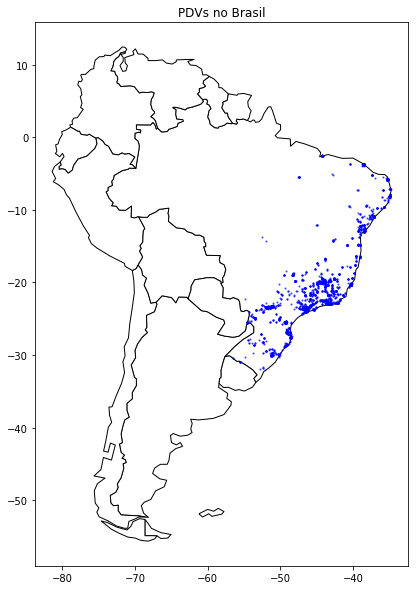

In [36]:

#CRIAR CORDENADAS
pdv['Coordinates'] = list(zip(pdv.Longitude, pdv.Latitude))
pdv['Coordinates'] = pdv['Coordinates'].apply(Point)
gdf = geopandas.GeoDataFrame(pdv, geometry='Coordinates')

#SELECIONAR MAPA
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# RESTRINGIR AMÉRICA DO SUL.
ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

# PLOT DO MAPA.
plt.rcParams['figure.figsize'] = [15, 10]
gdf.plot(ax=ax, color='blue', markersize = 1.5, alpha = 0.5)
plt.title('PDVs no Brasil')
plt.show()

In [25]:
#QUANTIDADE DE PDVS POR ESTADO
pdv['UF'].value_counts()

MG    821
SP    651
PR    352
RJ    334
BA    261
RS    150
SC    124
CE    119
ES     87
SE     60
PE     44
RN     42
MA     28
AL     24
PB     17
PI      2
MS      1
Name: UF, dtype: int64

In [26]:
#PDV POR ESTADO E TIPO
pdv.groupby(['UF', 'Tipo do PDV']).count()['Nome do PDV'].nlargest(20)

UF  Tipo do PDV       
MG  10 a 19 Check outs    440
    5 a 9 Check outs      267
RJ  10 a 19 Check outs    171
PR  10 a 19 Check outs    160
    20 a 49 Check outs    115
RS  10 a 19 Check outs    103
BA  10 a 19 Check outs     84
CE  10 a 19 Check outs     83
MG  20 a 49 Check outs     82
SC  10 a 19 Check outs     81
BA  1 a 4 Check outs       77
RJ  20 a 49 Check outs     73
    5 a 9 Check outs       72
BA  5 a 9 Check outs       70
PR  5 a 9 Check outs       65
ES  10 a 19 Check outs     48
PE  5 a 9 Check outs       31
MG  1 a 4 Check outs       30
SE  10 a 19 Check outs     30
RS  5 a 9 Check outs       29
Name: Nome do PDV, dtype: int64

In [27]:
# MAIORES BANDEIRAS
pdv['Bandeira'].value_counts().head(20)

BH                      150
EPA                     109
ATACADÃO S/A            102
G BARBOSA                70
BRETAS                   56
CIDADE CANÇÃO SUPERM     45
NAGUMO                   44
GUANABARA                42
CONDOR                   41
SUPER MUFFATO            41
BAHAMAS S.A              35
RISSUL                   32
SONDA                    32
ABC                      29
COOP                     27
PREZUNIC                 27
0                        26
CIA ZAFFARI              23
TENDA ATACADO            23
ROLDÃO                   23
Name: Bandeira, dtype: int64

## INSIGHTS #4 - PDV

- Os estados com maior número de PDVs listados.

        MG    821
        SP    651
        PR    352
        RJ    334
        BA    261
        RS    150
        
- Os Tipos de PDV com maior frequencia e seus respectivos estados.

        UF  Tipo do PDV       
        MG  10 a 19 Check outs    440
            5 a 9 Check outs      267
        RJ  10 a 19 Check outs    171
        PR  10 a 19 Check outs    160
            20 a 49 Check outs    115
        RS  10 a 19 Check outs    103
        BA  10 a 19 Check outs     84
        
- As Top 10 Bandeiras mais listadas.

        BH                      150
        EPA                     109
        ATACADÃO S/A            102
        G BARBOSA                70
        BRETAS                   56
        CIDADE CANÇÃO SUPERM     45
        NAGUMO                   44
        GUANABARA                42
        SUPER MUFFATO            41
        CONDOR                   41

In [28]:
prices = pd.read_excel('Base de Dados para Prova de Data Scientist v1.xlsx', sheet_name= 'Pesquisa de Preços')

prices.head()

,Marca,Categoria do Produto,Super Categoria,Linha de Produto,Rede,Bandeira,PDV,Estado,Cidade,Regional,Data e hora da Coleta,Colaborador Notificante,Produto Presente no PDV?,Preço:,O preço é promocional?
0,NESTLE,PERSONAL CRACKER,BISCOITO,NESFIT,SP BRASIL ATACADO VAREJ GEN LTDA LJ,NAGUMO,BOM BRASIL COM DE ALIMENTOS L 0001,São Paulo,Guarulhos,REGIONAL SAO PAULO,2017-12-30 11:53:52,Abel Malafaia,Ruptura,NaN,NaN
1,PANCO,CRACKERS,BISCOITO,PANCO MP,SP BRASIL ATACADO VAREJ GEN LTDA LJ,NAGUMO,BOM BRASIL COM DE ALIMENTOS L 0001,São Paulo,Guarulhos,REGIONAL SAO PAULO,2017-12-30 11:51:46,Abel Malafaia,Presente,5.89,Não
2,BAUDUCCO,CRACKERS,BISCOITO,CEREALE TB,SP BRASIL ATACADO VAREJ GEN LTDA LJ,NAGUMO,BOM BRASIL COM DE ALIMENTOS L 0001,São Paulo,Guarulhos,REGIONAL SAO PAULO,2017-12-30 11:51:46,Abel Malafaia,Ruptura,NaN,NaN
3,BAUDUCCO,CRACKERS,BISCOITO,BAUDUCCO TB,SP BRASIL ATACADO VAREJ GEN LTDA LJ,NAGUMO,BOM BRASIL COM DE ALIMENTOS L 0001,São Paulo,Guarulhos,REGIONAL SAO PAULO,2017-12-30 11:51:46,Abel Malafaia,Ruptura,NaN,NaN
4,PANCO,CRACKERS,BISCOITO,PANCO GERGELIM TB,SP BRASIL ATACADO VAREJ GEN LTDA LJ,NAGUMO,BOM BRASIL COM DE ALIMENTOS L 0001,São Paulo,Guarulhos,REGIONAL SAO PAULO,2017-12-30 11:51:46,Abel Malafaia,Ruptura,NaN,NaN


In [29]:
#selecionar colunas
prices = prices[['Marca', 'Categoria do Produto', 'Super Categoria','Linha de Produto',
                                  'Rede', 'Bandeira', 'Estado', 'Cidade',
                                  'Produto Presente no PDV?', 'Preço:', 'O preço é promocional?']]

#remover NAs
prices.dropna(inplace= True)
prices.head()

,Marca,Categoria do Produto,Super Categoria,Linha de Produto,Rede,Bandeira,Estado,Cidade,Produto Presente no PDV?,Preço:,O preço é promocional?
1,PANCO,CRACKERS,BISCOITO,PANCO MP,SP BRASIL ATACADO VAREJ GEN LTDA LJ,NAGUMO,São Paulo,Guarulhos,Presente,5.89,Não
5,MARILAN,CRACKERS,BISCOITO,MARILAN MANTEIGA MP,SP BRASIL ATACADO VAREJ GEN LTDA LJ,NAGUMO,São Paulo,Guarulhos,Presente,5.99,Não
6,MARILAN,CRACKERS,BISCOITO,MARILAN LIGHT MP,SP BRASIL ATACADO VAREJ GEN LTDA LJ,NAGUMO,São Paulo,Guarulhos,Presente,5.99,Não
7,MARILAN,CRACKERS,BISCOITO,MARILAN MP,SP BRASIL ATACADO VAREJ GEN LTDA LJ,NAGUMO,São Paulo,Guarulhos,Presente,5.99,Não
14,MARILAN,CRACKERS,BISCOITO,MARILAN INTEGRAL MP,SP BRASIL ATACADO VAREJ GEN LTDA LJ,NAGUMO,São Paulo,Guarulhos,Presente,5.99,Não


In [30]:
#CIDADES COM PREÇO MÉDIO MAIS ALTO
prices.groupby(['Estado', 'Cidade']).mean()['Preço:'].nlargest(20)

Estado     Cidade            
São Paulo  Araçatuba             5.220375
           Promissão             5.103793
           Santa Isabel          5.088714
           Birigui               5.057656
           Assis                 5.050917
           Barueri               5.040000
           Lins                  5.035748
           Cachoeira Paulista    4.974298
           Guararema             4.916375
           Fernandópolis         4.885750
           Cruzeiro              4.870855
           Osasco                4.797000
           Mongaguá              4.766806
           Bertioga              4.731148
           Cubatão               4.704146
           Itaquaquecetuba       4.703358
           Poá                   4.701926
           Santos                4.693985
           Lorena                4.683530
           Ubatuba               4.673105
Name: Preço:, dtype: float64

In [31]:
#SÓ TEM SAMPA
prices['Estado'].unique()

array(['São Paulo'], dtype=object)

In [32]:
# CIDADES COM MAIOR QUANTIDADE DE PROMOÇÕES
prices[prices['O preço é promocional?'] == 'Sim'].groupby(['Cidade']).count()['O preço é promocional?'].nlargest(20)

Cidade
São Paulo                537
Guarulhos                382
São José dos Campos      212
Caraguatatuba            124
Ferraz de Vasconcelos     96
Embu das Artes            68
Taubaté                   58
Santo André               53
Taboão da Serra           50
Poá                       48
São Bernardo do Campo     40
São Vicente               40
Carapicuíba               39
Campinas                  36
Caçapava                  36
Mogi das Cruzes           36
Suzano                    35
Birigui                   33
Atibaia                   32
Praia Grande              27
Name: O preço é promocional?, dtype: int64

In [33]:
#CATEGORIAS DE PRODUTOS MAIS CARAS
prices.groupby(['Categoria do Produto', 'Super Categoria']).mean()['Preço:'].nlargest(15)

Categoria do Produto  Super Categoria
AMANTEIGADOS          BISCOITO           6.670000
COOKIE INDULGÊNCIA    BISCOITO           6.490000
SALGADOS SORTIDOS     BISCOITO           6.188406
ROSQUINHAS            BISCOITO           5.120000
PERSONAL CRACKER      BISCOITO           4.772539
LAMINADO              BISCOITO           4.620753
CRACKERS              BISCOITO           4.513073
TORRADA EXTRUSADA     TORRADA            3.923544
COOKIE SAUDABILIDADE  BISCOITO           3.650000
MOLDADOS ESPECIAIS    BISCOITO           3.090000
WAFER                 BISCOITO           2.917732
RECHEADO DOCE         BISCOITO           2.590000
RECHEADO INFANTIL     BISCOITO           2.175000
Name: Preço:, dtype: float64

In [34]:
#MARCA E CATEGORIA MAIS CARA
prices.groupby(['Marca','Categoria do Produto']).mean()['Preço:'].nlargest(20)

Marca     Categoria do Produto
BAUDUCCO  AMANTEIGADOS            8.540000
          COOKIE INDULGÊNCIA      6.490000
PANCO     SALGADOS SORTIDOS       6.354498
MARILAN   SALGADOS SORTIDOS       5.917539
          AMANTEIGADOS            5.735000
PANCO     LAMINADO                5.472209
          ROSQUINHAS              5.190000
          CRACKERS                5.149115
MARILAN   ROSQUINHAS              5.050000
          CRACKERS                5.035815
          LAMINADO                4.976388
NESTLE    PERSONAL CRACKER        4.772539
TRIUNFO   LAMINADO                4.245933
          CRACKERS                4.129974
NESTLE    CRACKERS                3.984805
          LAMINADO                3.940568
BAUDUCCO  TORRADA EXTRUSADA       3.923544
          LAMINADO                3.853535
          COOKIE SAUDABILIDADE    3.650000
          CRACKERS                3.497021
Name: Preço:, dtype: float64

In [35]:
#PRODUTOS MAIS CAROS
prices.groupby(['Marca','Categoria do Produto']).max()['Preço:'].nlargest(20)

Marca     Categoria do Produto
PANCO     SALGADOS SORTIDOS       60.99
MARILAN   CRACKERS                50.99
          SALGADOS SORTIDOS       50.99
PANCO     CRACKERS                50.93
NESTLE    PERSONAL CRACKER        40.99
TRIUNFO   CRACKERS                40.91
MARILAN   LAMINADO                37.96
BAUDUCCO  TORRADA EXTRUSADA       33.93
NESTLE    CRACKERS                30.99
BAUDUCCO  LAMINADO                29.90
          CRACKERS                28.92
PANCO     WAFER                   20.99
NESTLE    WAFER                   15.99
BAUDUCCO  AMANTEIGADOS             8.54
TRIUNFO   LAMINADO                 7.49
PANCO     LAMINADO                 7.45
BAUDUCCO  COOKIE INDULGÊNCIA       6.49
MARILAN   AMANTEIGADOS             6.49
NESTLE    LAMINADO                 6.49
BAUDUCCO  WAFER                    6.29
Name: Preço:, dtype: float64

## INSIGHTS #5 - PREÇOS

- Baseado nos dados, podesse observar que a coleta de preços foi realizada somente no Estado de SP, já que não há preço para outros Estados.
       
- As cidades com maior média de preço são:

        São Paulo  Araçatuba             5.220375
                   Promissão             5.103793
                   Santa Isabel          5.088714
                   Birigui               5.057656
                   Assis                 5.050917
                   Barueri               5.040000
                   Lins                  5.035748


- As cidades com maior número de produtos com preços promocionais são:

        São Paulo                537
        Guarulhos                382
        São José dos Campos      212
        Caraguatatuba            124
        Ferraz de Vasconcelos     96
        Embu das Artes            68
        Taubaté                   58
        Santo André               53


- A categoria de produto com a média de preços mais alta são os AMANTEIGADOS com preço médio de R$6,67 


- A categoria de produto com a média de preços mais baixo são os RECHEADOS INFANTIS com preço médio de R$2,17 


- A Marca e categoria de produto com a média de preço mais alta são os AMANTEIGADOS da BAUDUCO com preço médio de R$8,54 


- O produto mais caro são os SALGADOS SORTIDOS da PANCO (R$60.99). Acredito que os produtos de valor superior a 15 reais devem se a embalagens grandes, também conhecidas como bulk, já que foram listadas em grandes atacados. Por este motivo o preço está muito acima da média.

# LIVE LONG AND PROSPER